In [1]:
# set up geo taggins for carto if needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from pathlib import Path
path = Path(r'C:\Users\40732\Desktop\jupyter\COVID')



In [2]:
#state flip
#FYI in the county level data, DC is ia 

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

#flip the other way
us_state_flip = {v:k for k,v in us_state_abbrev.items()}

#get the polygon lat/longs by us county

rf = requests.get(r'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')
fips_dict = rf.json()

In [3]:
#pull geometric shapes of counties to pull into carto
#Get the geometric points of the counties, scrubbing those that have extra set of [] on list
geo_dict = {d['properties']['STATE'] + d['properties']['COUNTY']:{d['geometry']['type']:d['geometry']['coordinates']} 
            if len(d['geometry']['coordinates']) > 1 else {d['geometry']['type']:d['geometry']['coordinates'][0]} for d in fips_dict['features']}

#get the fips codes with a multipolygon
mp = []
for k, v in geo_dict.items():
    if v.get('Polygon', None) == None:
        mp.append(k)
    
    #If it says polygon but the first entry is >2, must be a multi
    elif len(v['Polygon'][0]) > 2:
        geo_dict[k] = {'MultiPolygon':geo_dict[k]['Polygon']}
        mp.append(k)
    

#remove the extra [] from 2nd level of multipolygons
for i in mp:
    for c, l in enumerate(geo_dict[i]['MultiPolygon']):
        if len(l) == 1:
            geo_dict[i]['MultiPolygon'][c] = l[0]
            
#County name change in SD
geo_dict['46102'] = geo_dict['46113']

#Is a multi, says poly


In [ ]:
#test to see if there are double brack lists with lat/longs
flag = []
for k, v in geo_dict.items():
    if v.get('Polygon', None) == None:
        if len(v['MultiPolygon']) == 1:
            flag.append(k)
            print("here")

        else:
            for i in v['MultiPolygon']:
                if len(i) == 1:
                    flag.append(k)
                    print("here")
    else:
        if len(v['Polygon']) == 1:
            flag.append(k)
            print("here")
flag

In [4]:
# function to turn counties into polygons or multipolygons
def county_geo(gd):
    poly = []
    fips = [k for k in gd.keys()]
    for k in fips:
        try:
            if gd[k].get('Polygon') != None:
                poly.append(Polygon(gd[k].get('Polygon')))
            else:
                poly.append(MultiPolygon([Polygon(p) for p in geo_dict[k]['MultiPolygon']]))
        except:
            print(k)
            break
    return dict(zip(fips, poly))



In [5]:
poly_dict = county_geo(geo_dict)

In [6]:
#how to combine new york counties now that cases are being combined..
list_of_nyc = ['36061','36081', '36005', '36047', '36085']

ny = '36061'

In [12]:
df2_geo = pd.read_csv(path/'county_est_unemp_v2.csv', index_col=[0])
df2_geo['fips'] = df2_geo['fips'].apply(lambda x: str(x).zfill(5))
df2_geo['geometry'] = df2_geo['fips'].apply(lambda x: poly_dict.get(x))
#send to file out of git, for space
df2_geo.to_csv(r'C:\Users\40732\Desktop\jupyter\county_est_unemp_vGEO.csv')
df2_geo.sample(5)


,Date,County,State,Population,Cases,Deaths,Unemployment rate (02/20),fips,Share_ump,Est_claims,Initial_claims,Rate_insured_unemp,Mean age,% under 20,% over 65,Per capita income,geometry
159624,2020-03-18,Washington,New York,61204,1,0,4.8,36115.0,0.002502,152.186282,60825.071429,0.462500,42.467703,0.208246,0.194764,40043.0,None
103282,2020-03-02,Candler,Georgia,10803,0,0,2.7,13043.0,0.000690,0.831785,1204.821429,0.167500,39.205795,0.272794,0.180140,31385.0,None
80483,2020-02-24,Fergus,Montana,11050,0,0,4.6,30027.0,0.010956,1.918402,175.107143,0.587143,43.684514,0.228201,0.245118,43808.0,None
25706,2020-02-08,Holt,Nebraska,10067,0,0,2.6,31089.0,0.004574,0.614090,134.250000,0.112500,41.461780,0.271075,0.215858,51404.0,None
83079,2020-02-25,Vanderburgh,Indiana,181451,0,0,3.1,18163.0,0.024234,13.651292,563.321429,0.167143,39.504360,0.243919,0.168936,45893.0,None


In [14]:
df = df2_geo.loc[:, ['County', 'State', 'fips',]]
df.loc[:, 'Loc'] = df['County'] + ', ' + df['State']
df.drop_duplicates(subset=['Loc'], inplace=True)

In [15]:
#create the fips to geo mapping, required for Carto
df_fips = pd.DataFrame({'fips':[k for k in poly_dict.keys()]})
df_fips['geometry'] = df_fips['fips'].apply(lambda x: poly_dict[x])
df_fips = pd.merge(df_fips, df, how='left', on='fips')
df_fips = gpd.GeoDataFrame(df_fips, geometry = 'geometry')
df_fips['Centroid'] = df_fips.centroid
df_fips.to_csv(path/'fips_and_counties.csv')

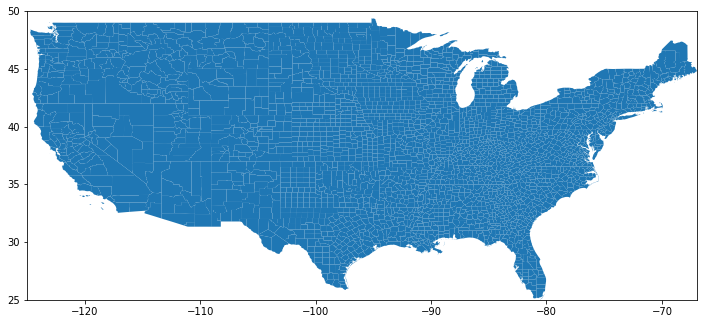

In [16]:

fig, ax = plt.subplots(1, figsize=(12, 12))
ax = df_fips.plot(ax=ax)
plt.xlim(-125, -67)
plt.ylim(25, 50)
plt.show()

In [ ]:
city_map = pd.read_csv(r'https://cdn.citymapper.com/data/cmi/Citymapper_Mobility_Index_20200417.csv', header=[3])
list_to_see = ['Chicago', 'Boston', 'New York City', 'Philadelphia', 'San Francisco', 'Seattle', 'Washington DC', 'Milan', 'Hong Kong']
city_map[list_to_see].plot()

In [ ]:
# Apple mobility data

apple_url = 'https://covid19-static.cdn-apple.com/covid19-mobility-data/2007HotfixDev42/v2/en-us/applemobilitytrends-2020-04-28.csv'


apple = pd.read_csv(apple_url)
apple.drop(['alternative_name'], axis=1, inplace=True)
apple.sample(5)

r'''
#csv url changes by day, attempts to automate fetch failed
driver = webdriver.Chrome(executable_path="C:/Users/40732/chromedriver.exe")
driver.get('https://www.apple.com/covid19/mobility')
#driver.find_element_by_class_name('download-button-container').text


xpath = '/html/body/div[1]/div/ui-main-pane/div[2]/div[3]/div[2]'

xpath = '//a[@href="'+'https://covid19-static.cdn-apple.com/covid19-mobility-data/'+'"]'
#out = driver.find_element_by_xpath(xpath).get_attribute('outerHTML')
out = driver.find_element_by_class_name('download-button-container').get_attribute('outerHTML')

driver.close()
apple_url = out[out.find('https'):out.find('.csv')+4]
out
'''
''


### Mobility trends


list_keep = ['New York City', 'Baltimore', 'Boston', 'San Francisco - Bay Area', 'Chicago', 'Dallas', 'Seattle', 'Houston', 'Detroit', 'Miami', 'Atlanta',
             'United States', 'Washington DC', 'Denver', 'Philadelphia']

apple.drop(apple[~apple['region'].isin(list_keep)].index, axis=0, inplace=True)

for c in apple.columns[4:]:
    apple.loc[:, c] = pd.to_numeric(apple.loc[:, c])

new_apple = apple.melt(id_vars = ['geo_type', 'region', 'transportation_type'], var_name='Date', value_name='Score').drop(
    'geo_type', axis=1).pivot_table(index=['region', 'Date'], columns = 'transportation_type').reset_index()

new_apple.columns = ['City', 'Date', 'Driving', 'Transit', 'Walking']

new_apple['State'] = new_apple['City'].apply(lambda x: us_state_flip.get(dict_city[x].strip()))
new_apple['Latitude'] = new_apple['City'].apply(lambda x: ll_dict[x][0])
new_apple['Longitude'] = new_apple['City'].apply(lambda x: ll_dict[x][1])

new_apple.loc[new_apple['City'] == 'San Francisco - Bay Area', 'City'] = 'San Francisco'
new_apple.to_csv(path/'Apple_mobility.csv')


#df2.append(new_apple).to_csv(path/'county_est_unemp_v3.csv')

new_apple.sample(5)

#df2.sample(5)